---
format:
    html:
        embed-resources: true
---

# High-level Data Overview from Source:

1. GameID: Unique ID number for each game (integer)
2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
3. Age: Age of each player (integer)
4. HoursPerWeek: Reported hours spent playing per week (integer)
5. TotalHours: Reported total hours spent playing (integer)
6. APM: Action per minute (continuous)
7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
12. NumberOfPACs: Number of PACs per timestamp (continuous)
13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
15. ActionsInPAC: Mean number of actions within each PAC (continuous)
16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Grad/DSAN5300/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Grad/DSAN5300


# Imports

In [46]:
# project step 1
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ensemble modelings
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pickle

# Data Overview

In [47]:
# read in data
df = pd.read_csv('starcraft.csv')
print(df.columns)
print(df.shape)

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilityUsed', 'MaxTimeStamp'],
      dtype='object')
(3395, 21)


In [48]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GameID              3395 non-null   int64  
 1   LeagueIndex         3395 non-null   int64  
 2   Age                 3340 non-null   float64
 3   HoursPerWeek        3339 non-null   float64
 4   TotalHours          3338 non-null   float64
 5   APM                 3395 non-null   float64
 6   SelectByHotkeys     3395 non-null   float64
 7   AssignToHotkeys     3395 non-null   float64
 8   UniqueHotkeys       3395 non-null   float64
 9   MinimapAttacks      3395 non-null   float64
 10  MinimapRightClicks  3395 non-null   float64
 11  NumberOfPACs        3395 non-null   float64
 12  GapBetweenPACs      3395 non-null   float64
 13  ActionLatency       3395 non-null   float64
 14  ActionsInPAC        3395 non-null   float64
 15  TotalMapExplored    3395 non-null   float64
 16  Worker

In [49]:
print(df['LeagueIndex'].value_counts()) # target variable

LeagueIndex
4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: count, dtype: int64


# Preprocessing

In [50]:
# drop NaNs
df = df.dropna()
print(df.isna().sum())

GameID                0
LeagueIndex           0
Age                   0
HoursPerWeek          0
TotalHours            0
APM                   0
SelectByHotkeys       0
AssignToHotkeys       0
UniqueHotkeys         0
MinimapAttacks        0
MinimapRightClicks    0
NumberOfPACs          0
GapBetweenPACs        0
ActionLatency         0
ActionsInPAC          0
TotalMapExplored      0
WorkersMade           0
UniqueUnitsMade       0
ComplexUnitsMade      0
ComplexAbilityUsed    0
MaxTimeStamp          0
dtype: int64


In [51]:
# remove uninformative cols
df = df.drop('GameID', axis=1)

# EDA

## Correlation Plot

In [52]:
df_numeric = df.select_dtypes(include=['number'])
corr = df_numeric.corr()
print(corr)

                    LeagueIndex       Age  HoursPerWeek  TotalHours       APM  \
LeagueIndex            1.000000 -0.127518      0.217930    0.023884  0.624171   
Age                   -0.127518  1.000000     -0.184431   -0.016630 -0.210724   
HoursPerWeek           0.217930 -0.184431      1.000000    0.024306  0.246897   
TotalHours             0.023884 -0.016630      0.024306    1.000000  0.072850   
APM                    0.624171 -0.210724      0.246897    0.072850  1.000000   
SelectByHotkeys        0.428637 -0.131105      0.205792    0.081830  0.814624   
AssignToHotkeys        0.487279 -0.104960      0.158315    0.042415  0.534133   
UniqueHotkeys          0.260882 -0.004889      0.062275    0.007953  0.285059   
MinimapAttacks         0.270525  0.043098      0.084104    0.000874  0.218562   
MinimapRightClicks     0.206380 -0.019904      0.049498    0.007662  0.306391   
NumberOfPACs           0.589194 -0.197128      0.174871    0.039577  0.635248   
GapBetweenPACs        -0.537

**Observations:**

1. `APM` has a very strong positive correlation with `SelectByHotkeys` (0.814624), which makes sense, since selecting units or buildings would contribute to a player's APM.
2. `APM` has a strong negative correlation with `ActionLatency` (-0.722253), which makes sense, since higher APM would require a player make more actions (i.e. less time in-between each action).

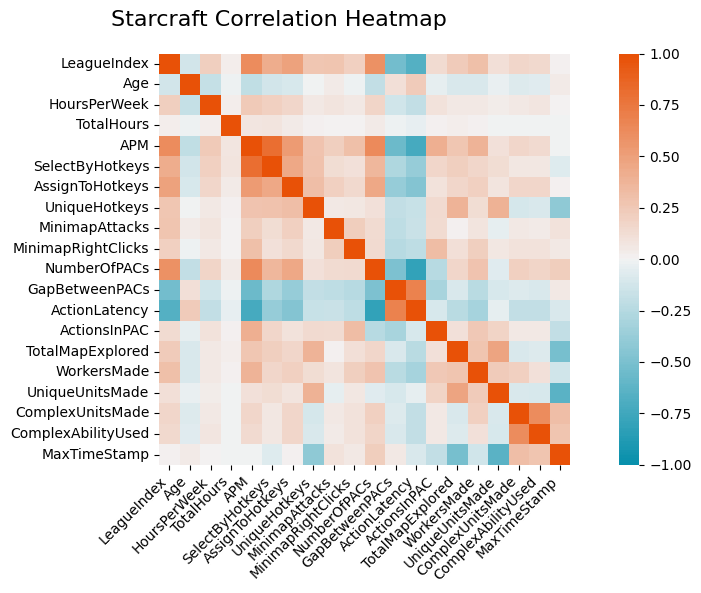

In [53]:
cmap = sns.diverging_palette(220, 20, s=99, l=55, n=200)

plt.figure(figsize=(10, 6))
sns.heatmap(
  corr,
  vmin=-1, vmax=1, center=0,
  cmap=cmap,
  square=True
)
plt.xticks(rotation=45, horizontalalignment='right')
plt.suptitle("Starcraft Correlation Heatmap", ha='center', size=16)

plt.tight_layout()
plt.show()

## Distribution Plots

In [54]:
df['TotalHours'].describe()

count       3338.000000
mean         960.421809
std        17318.133922
min            3.000000
25%          300.000000
50%          500.000000
75%          800.000000
max      1000000.000000
Name: TotalHours, dtype: float64

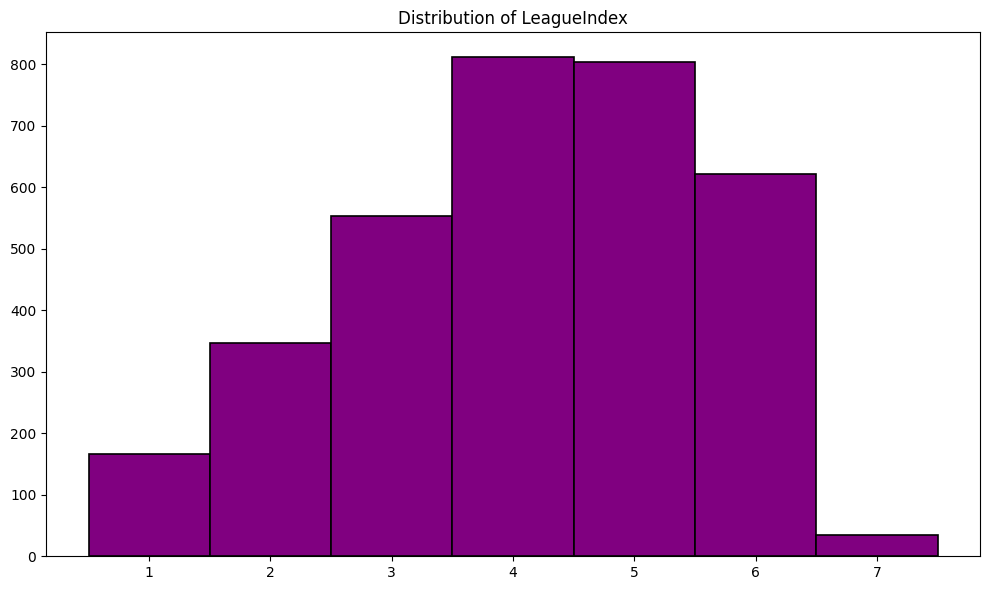

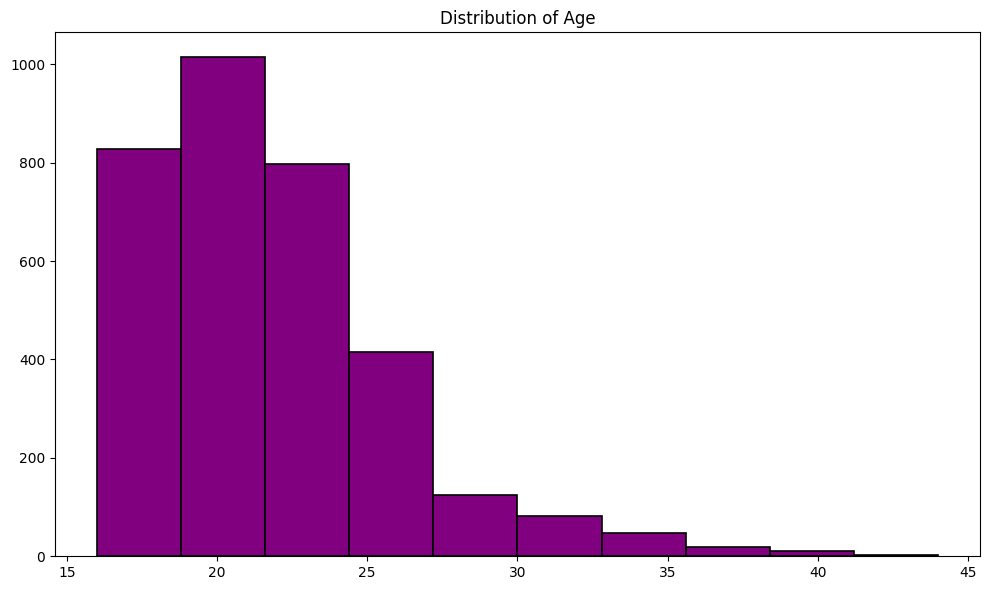

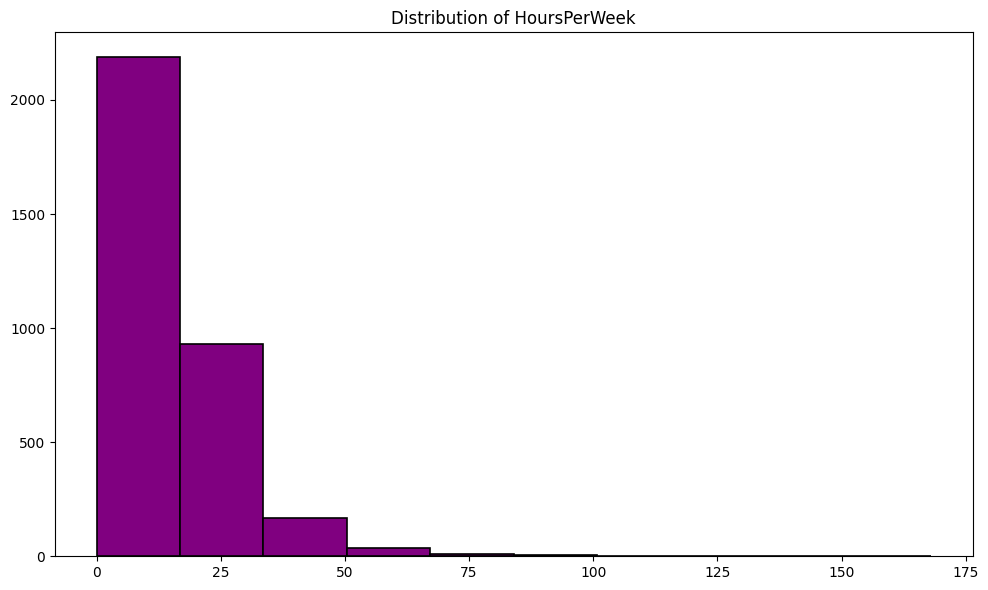

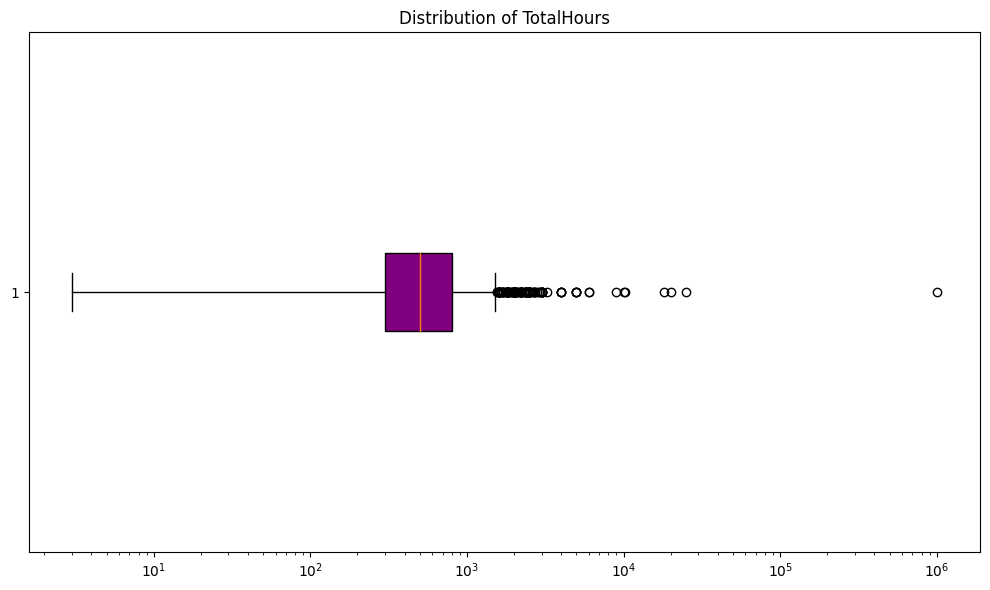

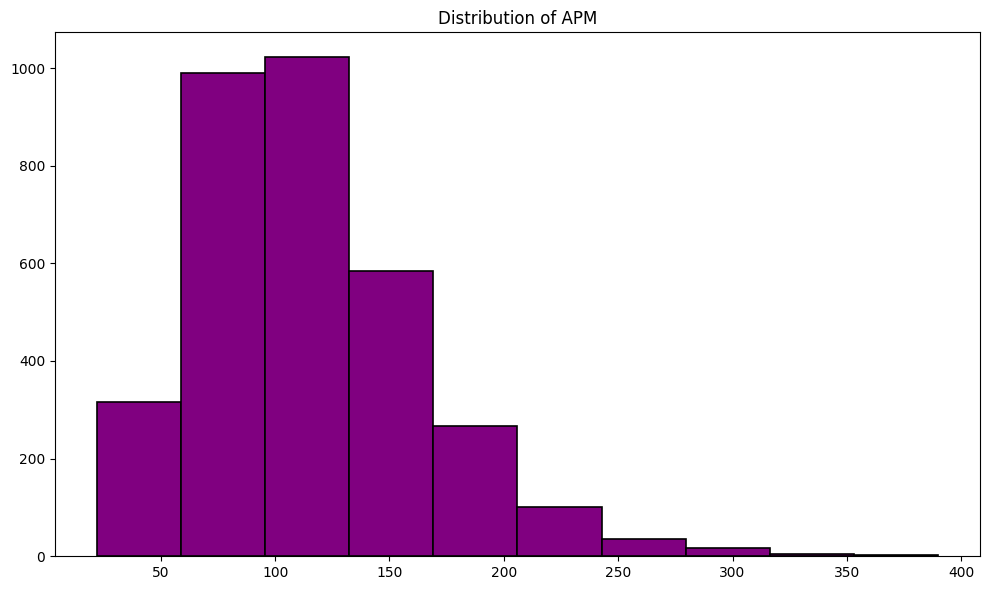

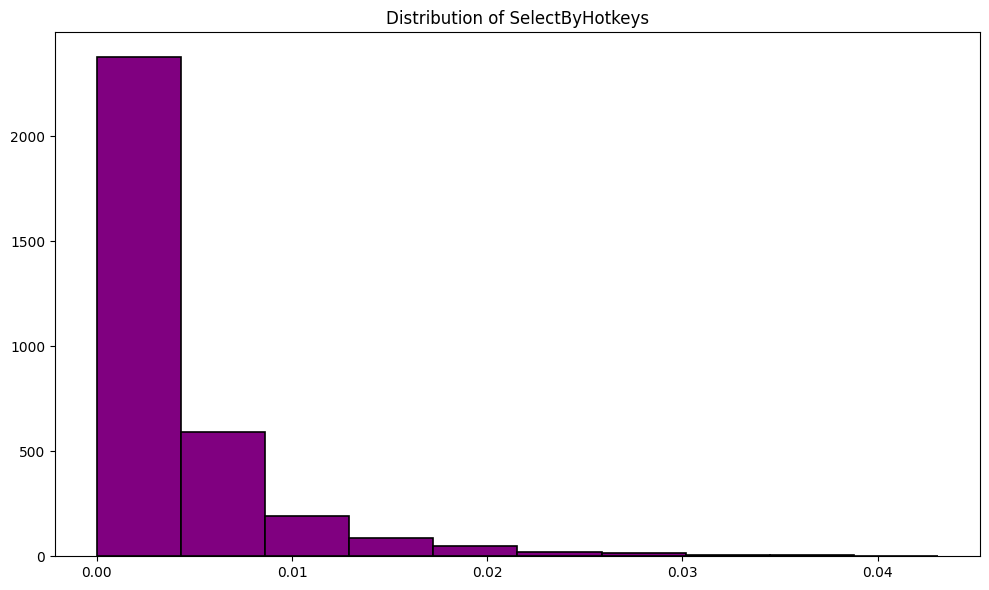

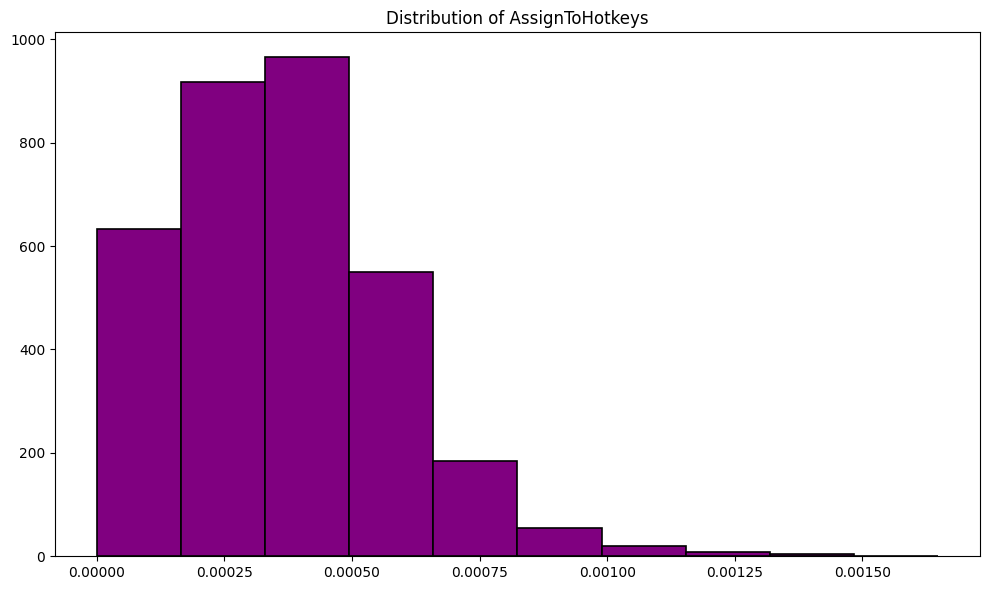

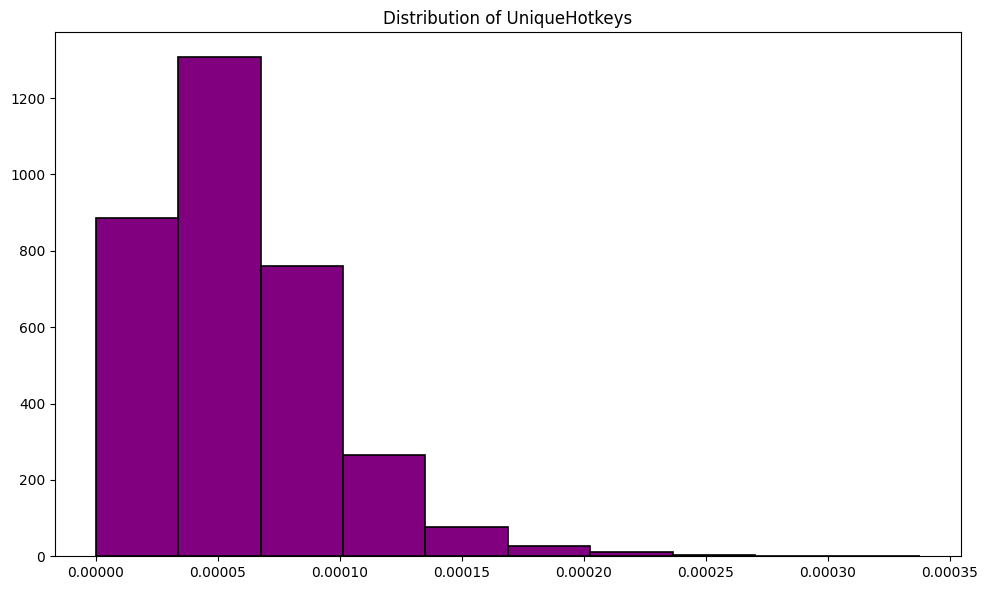

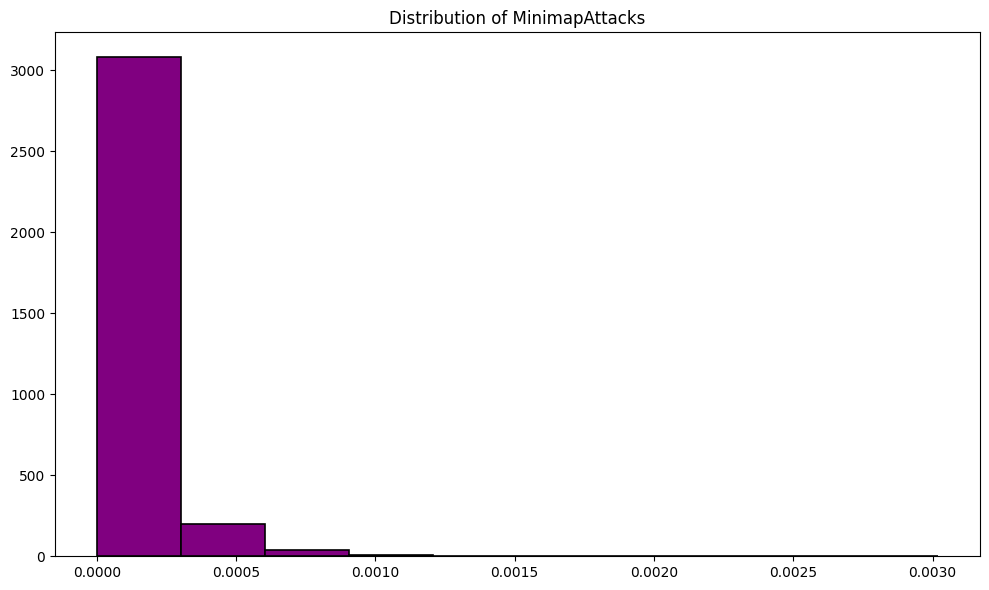

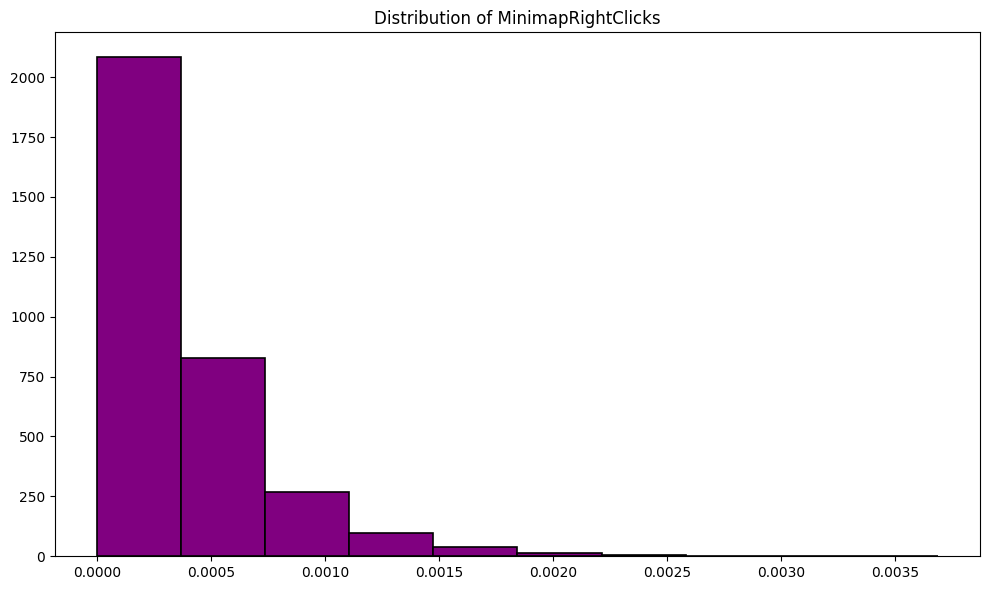

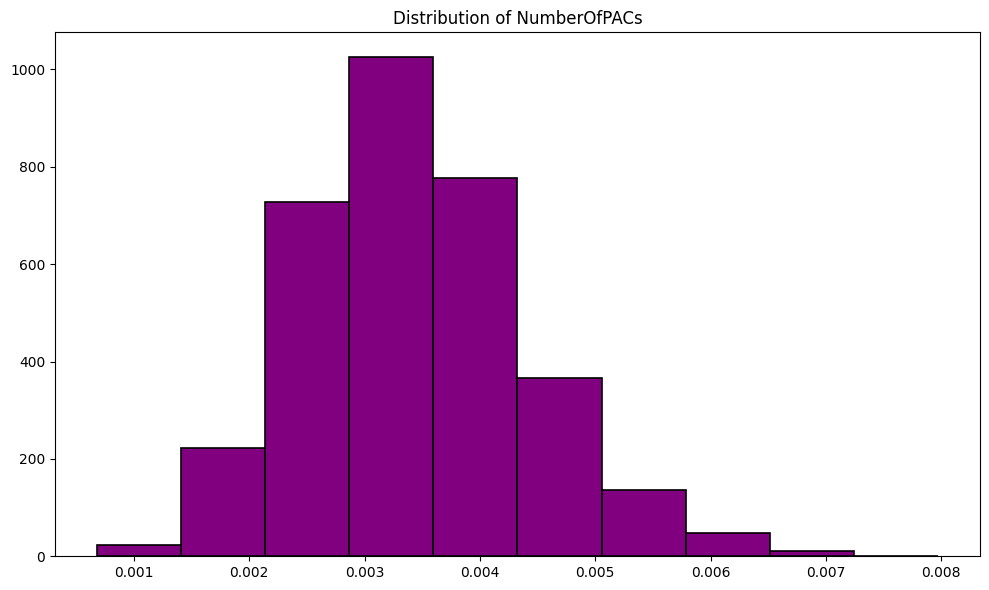

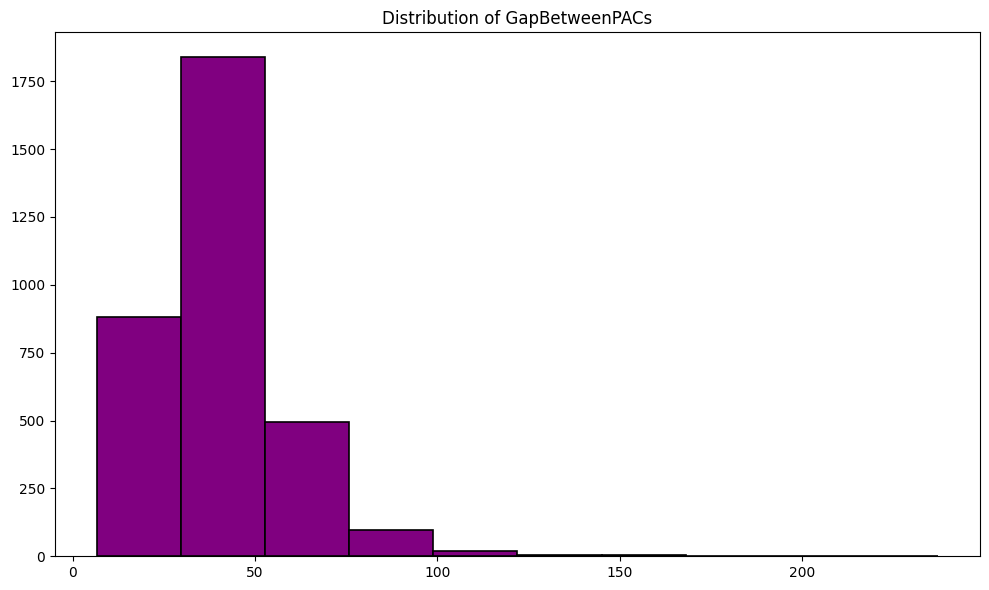

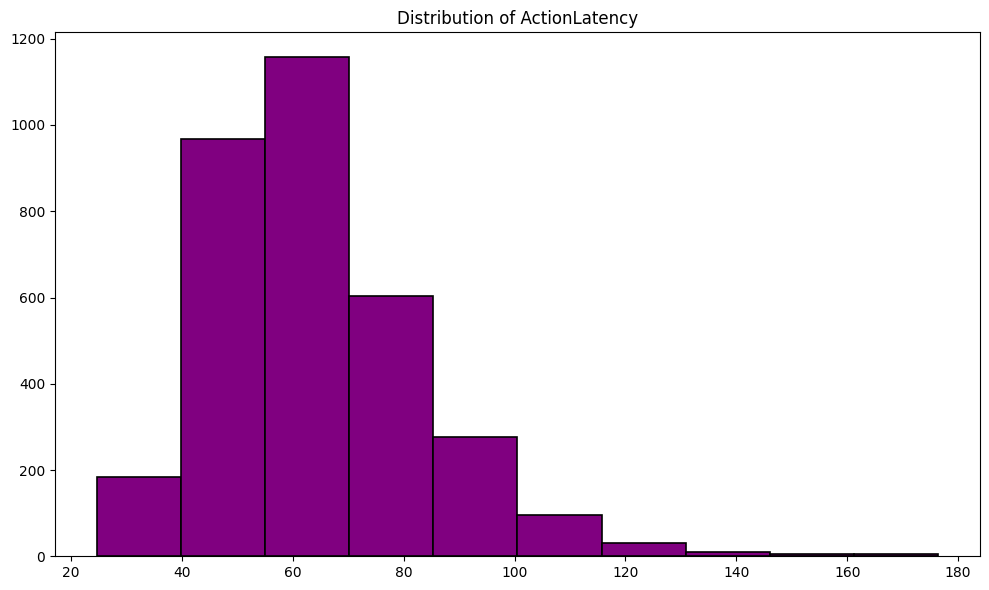

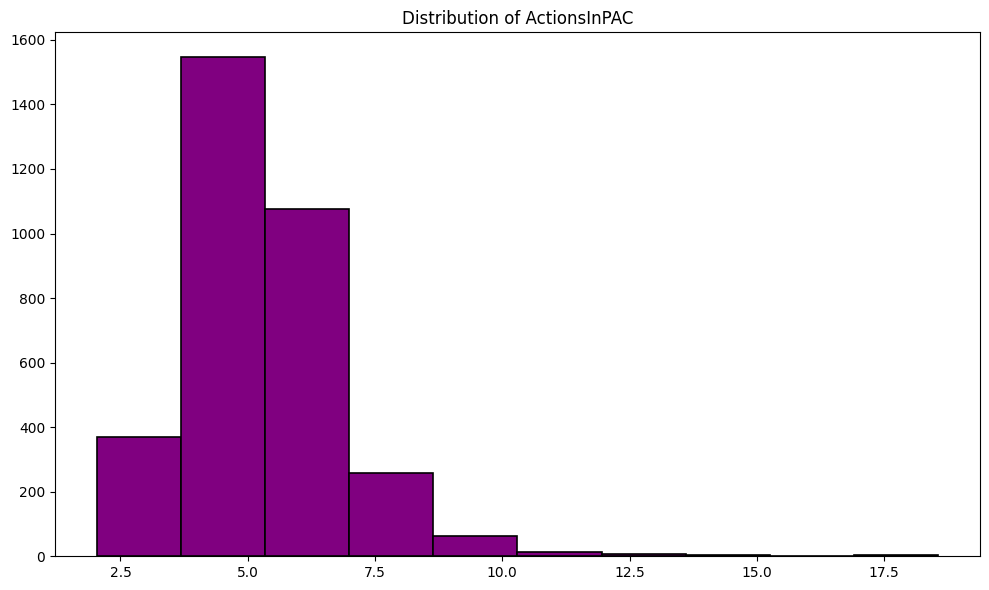

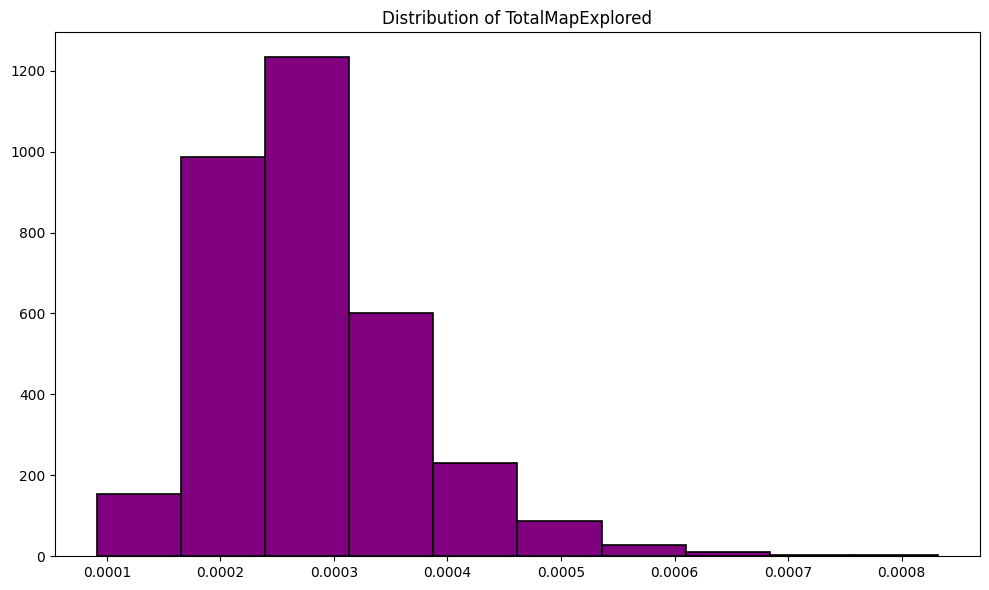

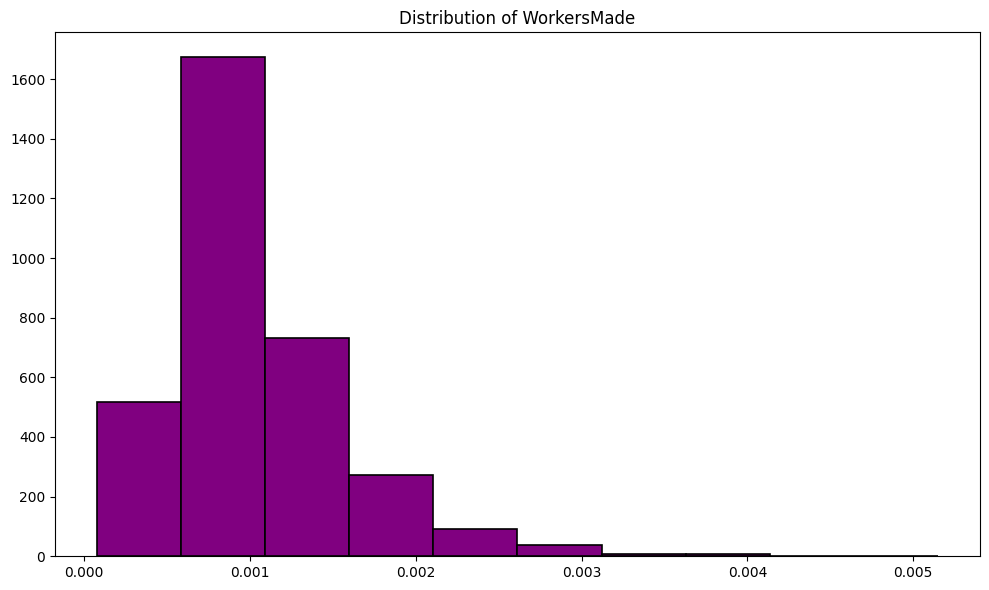

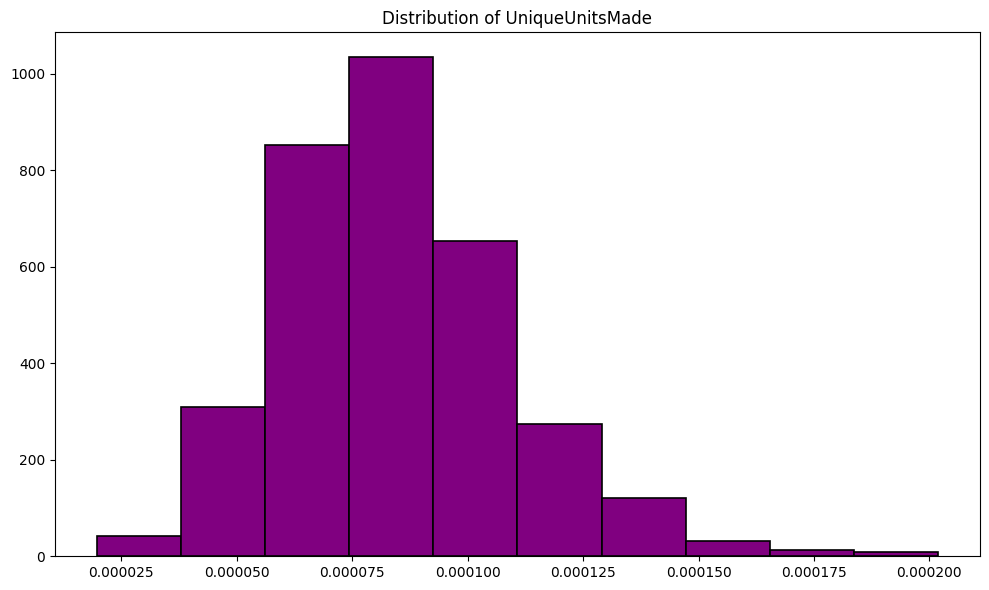

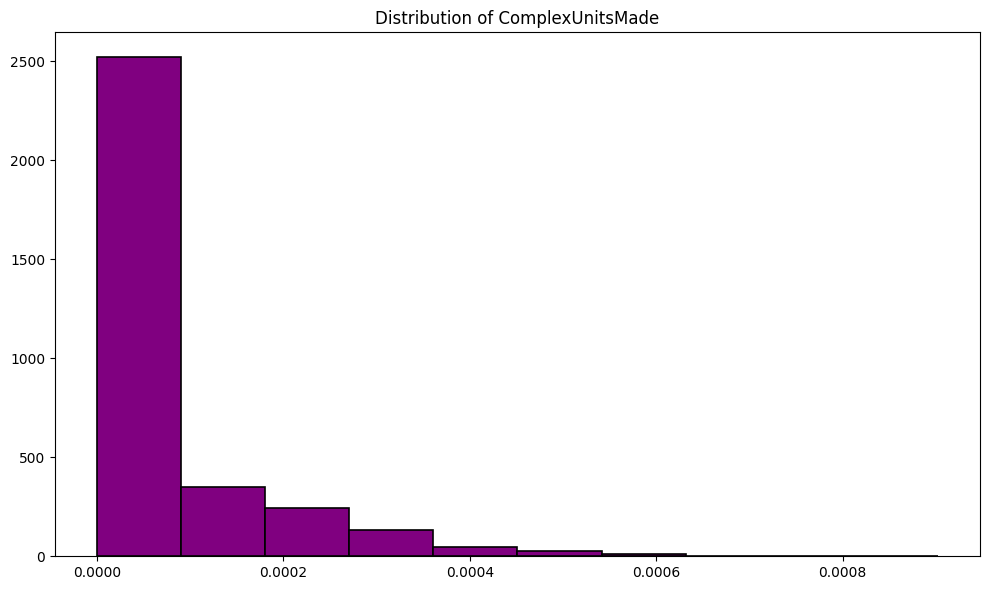

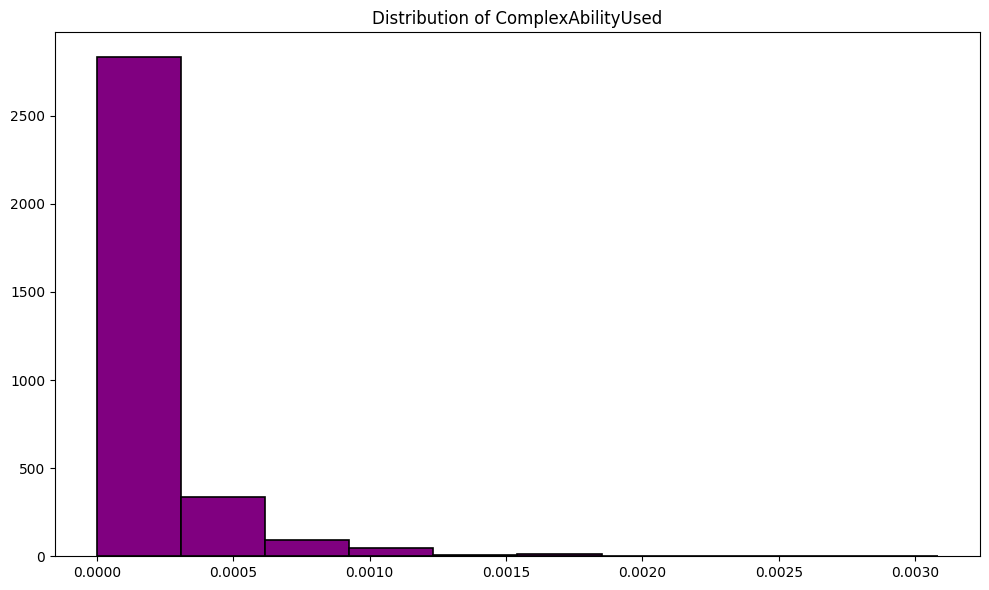

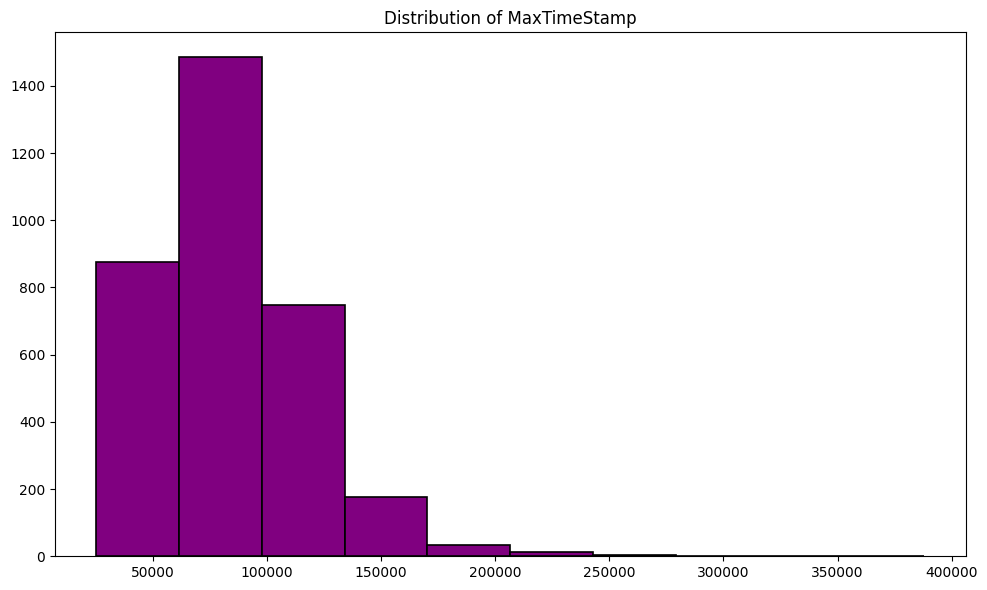

In [55]:
for i, column in enumerate(df.columns):
  plt.figure(figsize=(10, 6))

  # arbitrarily checking if column is categorical / ordinal / discrete
  if df[column].dtype == 'object' or df[column].nunique() < 10:
    values = sorted(df[column].unique())
    plt.hist(df[column], bins=np.arange(min(values) - 0.5, max(values) + 1.5, 1),
             color='purple', edgecolor='black', linewidth=1.2)
    plt.xticks(values) # set xticks to match discrete values
  else:
    if column == 'TotalHours':
      plt.boxplot(df[column], boxprops=dict(facecolor='purple'), vert=False, patch_artist=True)
      plt.xscale('log')
    else:
      plt.hist(df[column], color='purple', edgecolor='black', linewidth=1.2)

  plt.title(f"Distribution of {column}", size=12)
  plt.grid(False) # grid off
  plt.tight_layout()
  plt.show()

**Observations:**

1. `LeagueIndex` (target variable): Most players reside in Gold, Platinum, and Diamond
2. Most of the features are right-skewed.
3. Some of the normal-looking features are: `NumberOfPACs`, `UniqueUnitsMade`

# Modeling

## Eval w/ Accuracy

In [56]:
X = df.drop(columns=['LeagueIndex'])
y = df['LeagueIndex'] - 1 # -1 to index from 0

# train-test 70-15-15 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=1859) # stratify to handle imbalance
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                stratify=y_test, random_state=1859)


In [57]:
# sanity check
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

LeagueIndex
3    567
4    563
5    435
2    387
1    243
0    117
6     24
Name: count, dtype: int64
LeagueIndex
3    122
4    121
5     93
2     83
1     52
0     25
6      5
Name: count, dtype: int64
LeagueIndex
3    122
4    120
5     93
2     83
1     52
0     25
6      6
Name: count, dtype: int64


In [58]:
# df to keep track of model metrics
metrics_df = pd.DataFrame(columns=['Model', 'Condition', 'isBalanced',
                                   'Accuracy', 'ROC AUC Score',
                                   'Confusion Matrix', 'Classification Report'])

# helper function
def evaluate(y_test, y_pred, y_prob, model_name, condition, is_balanced):
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  report = classification_report(y_test, y_pred, output_dict=True)
  roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo', average='weighted')

  # append
  metrics_df.loc[len(metrics_df)] = [model_name, condition,
                                     is_balanced, accuracy, roc_auc,
                                     conf_matrix, report]

## Logistic Regression Baseline

In [59]:
lr_clf = LogisticRegression(penalty='elasticnet', l1_ratio = 0, solver = 'saga',
                            random_state=1859)
lr_clf.fit(X_train, y_train)

# predict
y_pred = lr_clf.predict(X_test)
y_prob = lr_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'LR', 'Baseline', 'No')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

## Logistic Regression Hyperparameter Tuning

In [60]:
param_grid = {
    'penalty' : ['elasticnet'],
    'solver' : ['saga'],
    'l1_ratio' : np.linspace(0,1,5),
    'C' : [0.01, 0.1, 1, 10]
}

# grid search
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'LR', 'Tuned for Accuracy', 'No')
# print(metrics_df)

Best parameters found:  {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

## SVM Baseline

In [61]:
svm_clf = SVC(class_weight='balanced', probability=True, random_state=1859)
svm_clf.fit(X_train, y_train)

# predict
y_pred = svm_clf.predict(X_test)
y_prob = svm_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'SVM', 'Baseline', 'No')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM Hyperparameter Tuning

In [62]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3, 4] # for poly kernel
}

# grid search
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'SVM', 'Tuned for Accuracy', 'No')
# print(metrics_df)

Best parameters found:  {'C': 0.1, 'degree': 2, 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Baseline

In [63]:
rf_clf = RandomForestClassifier(random_state=1859)
rf_clf.fit(X_train, y_train)

# predict
y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'Random Forest', 'Baseline', 'No')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Hyperparameter Tuning

In [64]:
# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# grid search
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'Random Forest', 'Tuned for Accuracy', 'No')
# print(metrics_df)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost Baseline

In [65]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=1859)
xgb_clf.fit(X_train, y_train)

# predict
y_pred = xgb_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'XGBoost', 'Baseline', 'No')
# print(metrics_df)

## XGBoost Hyperparameter Tuning

In [66]:
# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
}

# grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'XGBoost', 'Tuned for Accuracy', 'No')
# print(metrics_df)

Best parameters found:  {'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Honestly, none of these methods are all that great. Going to retry using SMOTE (Synthetic Minority Oversampling Technique). SMOTE finds a minority class observation's k-nn to generate new samples that are a combination of the features of the minority class sample and its neighbors.

# Redo Modeling w/ Data Set Rebalance

## Rebalancing

In [67]:
# ref: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1859)
X_train_rebal, y_train_rebal = sm.fit_resample(X_train, y_train)


# sanity check
print(y_train_rebal.value_counts())

LeagueIndex
4    567
2    567
5    567
1    567
3    567
0    567
6    567
Name: count, dtype: int64


## Logistic Regression Baseline

In [68]:
lr_clf = LogisticRegression(penalty='elasticnet', l1_ratio = 0, solver = 'saga',
                            random_state=1859)
lr_clf.fit(X_train_rebal, y_train_rebal)

# predict
y_pred = lr_clf.predict(X_test)
y_prob = lr_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'LR', 'Baseline', 'Yes')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

## Logistic Regression Hyperparameter Tuning

In [69]:
param_grid = {
    'penalty' : ['elasticnet'],
    'solver' : ['saga'],
    'l1_ratio' : np.linspace(0,1,5),
    'C' : [0.01, 0.1, 1, 10]
}

# grid search
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'LR', 'Tuned for Accuracy', 'Yes')
# print(metrics_df)

Best parameters found:  {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

## SVM Baseline

In [70]:
svm_clf = SVC(probability=True, random_state=1859)
svm_clf.fit(X_train_rebal, y_train_rebal)

# predict
y_pred = svm_clf.predict(X_test)
y_prob = svm_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'SVM', 'Baseline', 'Yes')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM Hyperparameter Tuning

In [71]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3, 4] # for poly kernel
}

# grid search
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'SVM', 'Tuned for Accuracy', 'Yes')
# print(metrics_df)

Best parameters found:  {'C': 1, 'degree': 2, 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RF Baseline

In [72]:
rf_clf = RandomForestClassifier(random_state=1859)
rf_clf.fit(X_train_rebal, y_train_rebal)

# predict
y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'Random Forest', 'Baseline', 'Yes')
# print(metrics_df)

## RF Hyperparameter Tuning

In [73]:
# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# grid search
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'Random Forest', 'Tuned for Accuracy', 'Yes')
# print(metrics_df)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost Baseline

In [74]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=1859)
xgb_clf.fit(X_train_rebal, y_train_rebal)

# predict
y_pred = xgb_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'XGBoost', 'Baseline', 'Yes')
# print(metrics_df)

## XGBoost Hyperparameter Tuning

In [75]:
# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
}

# grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'XGBoost', 'Tuned for Accuracy', 'Yes')
# print(metrics_df)

Best parameters found:  {'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Eval w/ ROC-AUC Score

## Logistic Regression Unbalanced

In [76]:
lr_clf = LogisticRegression(penalty='elasticnet', l1_ratio = 0, solver='saga',
                            random_state=1859)
lr_clf.fit(X_train, y_train)

param_grid = {
    'penalty' : ['elasticnet'],
    'solver' : ['saga'],
    'l1_ratio' : np.linspace(0,1,5),
    'C' : [0.01, 0.1, 1, 10]
}

# grid search
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'LR', 'Tuned for ROC AUC', 'No')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found:  {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 


## SVM Unbalanced

In [77]:
svm_clf = SVC(class_weight='balanced', probability=True, random_state=1859)
svm_clf.fit(X_train, y_train)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3, 4] # for poly kernel
}

# grid search
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'SVM', 'Tuned for ROC AUC', 'No')
# print(metrics_df)

Best parameters found:  {'C': 0.1, 'degree': 2, 'kernel': 'poly'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RF Unbalanced

In [78]:
rf_clf = RandomForestClassifier(random_state=1859)
rf_clf.fit(X_train, y_train)

# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# grid search
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'Random Forest', 'Tuned for ROC AUC', 'No')
# print(metrics_df)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost Unbalanced

In [79]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=1859)
xgb_clf.fit(X_train, y_train)

# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
}

# grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'XGBoost', 'Tuned for ROC AUC', 'No')
# print(metrics_df)

Best parameters found:  {'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}


## Logistic Regression Balanced

In [80]:
lr_clf = LogisticRegression(penalty='elasticnet', l1_ratio = 0, solver='saga',
                            random_state=1859)
lr_clf.fit(X_train, y_train)

param_grid = {
    'penalty' : ['elasticnet'],
    'solver' : ['saga'],
    'l1_ratio' : np.linspace(0,1,5),
    'C' : [0.01, 0.1, 1, 10]
}

# grid search
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'LR', 'Tuned for ROC AUC', 'Yes')
# print(metrics_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found:  {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

## SVM Balanced

In [81]:
svm_clf = SVC(probability=True, random_state=1859)
svm_clf.fit(X_train_rebal, y_train_rebal)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3, 4] # for poly kernel
}

# grid search
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'SVM', 'Tuned for ROC AUC', 'Yes')
# print(metrics_df)

Best parameters found:  {'C': 10, 'degree': 2, 'kernel': 'poly'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RF Balanced

In [82]:
rf_clf = RandomForestClassifier(random_state=1859)
rf_clf.fit(X_train_rebal, y_train_rebal)

# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# grid search
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'Random Forest', 'Tuned for ROC AUC', 'Yes')
# print(metrics_df)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost Balanced

In [83]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=1859)
xgb_clf.fit(X_train_rebal, y_train_rebal)

# hyperparams
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
}

# grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='roc_auc_ovo_weighted')
grid_search.fit(X_val, y_val)
print("Best parameters found: ", grid_search.best_params_)

# use best params for pred
y_pred = grid_search.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)

# metrics
evaluate(y_test, y_pred, y_prob, 'XGBoost', 'Tuned for ROC AUC', 'Yes')
# print(metrics_df)

Best parameters found:  {'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}


# Model Comparisons

In [84]:
metrics_df

,Model,Condition,isBalanced,Accuracy,ROC AUC Score,Confusion Matrix,Classification Report
0,LR,Baseline,No,0.257485,0.535632,"[[0, 0, 0, 25, 0, 0, 0], [0, 0, 0, 51, 1, 0, 0...","{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc..."
1,LR,Tuned for Accuracy,No,0.247505,0.564122,"[[0, 0, 0, 25, 0, 0, 0], [0, 0, 0, 52, 0, 0, 0...","{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc..."
2,SVM,Baseline,No,0.137725,0.505484,"[[0, 7, 0, 0, 12, 0, 6], [0, 9, 0, 0, 21, 0, 2...","{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc..."
3,SVM,Tuned for Accuracy,No,0.173653,0.486328,"[[5, 0, 0, 0, 0, 20, 0], [5, 0, 0, 0, 0, 47, 0...","{'0': {'precision': 0.07936507936507936, 'reca..."
4,Random Forest,Baseline,No,0.391218,0.800769,"[[7, 11, 4, 3, 0, 0, 0], [5, 18, 14, 13, 1, 1,...","{'0': {'precision': 0.4375, 'recall': 0.28, 'f..."
5,Random Forest,Tuned for Accuracy,No,0.367265,0.800769,"[[5, 12, 5, 2, 1, 0, 0], [6, 13, 21, 9, 3, 0, ...","{'0': {'precision': 0.38461538461538464, 'reca..."
6,XGBoost,Baseline,No,0.387226,0.800769,"[[9, 6, 5, 5, 0, 0, 0], [7, 15, 14, 14, 1, 1, ...","{'0': {'precision': 0.4090909090909091, 'recal..."
7,XGBoost,Tuned for Accuracy,No,0.387226,0.800769,"[[3, 16, 3, 2, 1, 0, 0], [5, 15, 15, 14, 3, 0,...","{'0': {'precision': 0.25, 'recall': 0.12, 'f1-..."
8,LR,Baseline,Yes,0.011976,0.619512,"[[0, 0, 0, 0, 0, 0, 25], [0, 0, 0, 0, 0, 0, 52...","{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc..."
9,LR,Tuned for Accuracy,Yes,0.247505,0.564122,"[[0, 0, 0, 25, 0, 0, 0], [0, 0, 0, 52, 0, 0, 0...","{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc..."


In [85]:
metrics_df['Model_Configuration'] = metrics_df['Model'] + "_" + metrics_df['Condition'] + "_" + metrics_df['isBalanced']

In [86]:
def plot_metric_comparison(df, metric_column, title, color='skyblue',
                           figsize=(14, 8)):
  df_sorted = df.sort_values(metric_column, ascending=True)

  # plot
  plt.figure(figsize=figsize)
  bars = plt.barh(df_sorted['Model_Configuration'], df_sorted[metric_column],
                  color=color)
  plt.xlabel(metric_column)
  plt.title(title)

  # add labels
  for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.3f}", va='center', ha='left')

  plt.tight_layout()
  plt.show()

## Accuracy

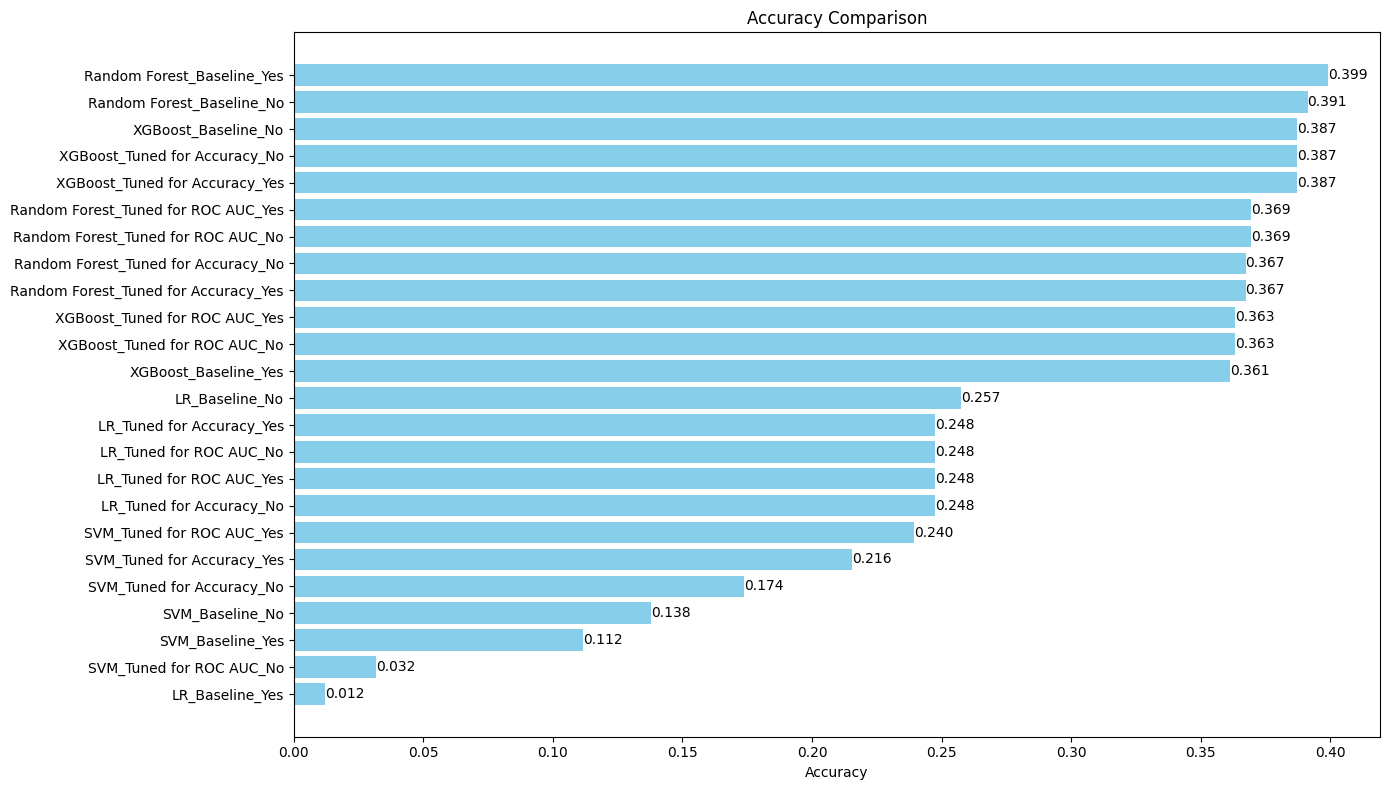

In [87]:
plot_metric_comparison(metrics_df, 'Accuracy', 'Accuracy Comparison')

## ROC-AUC Score

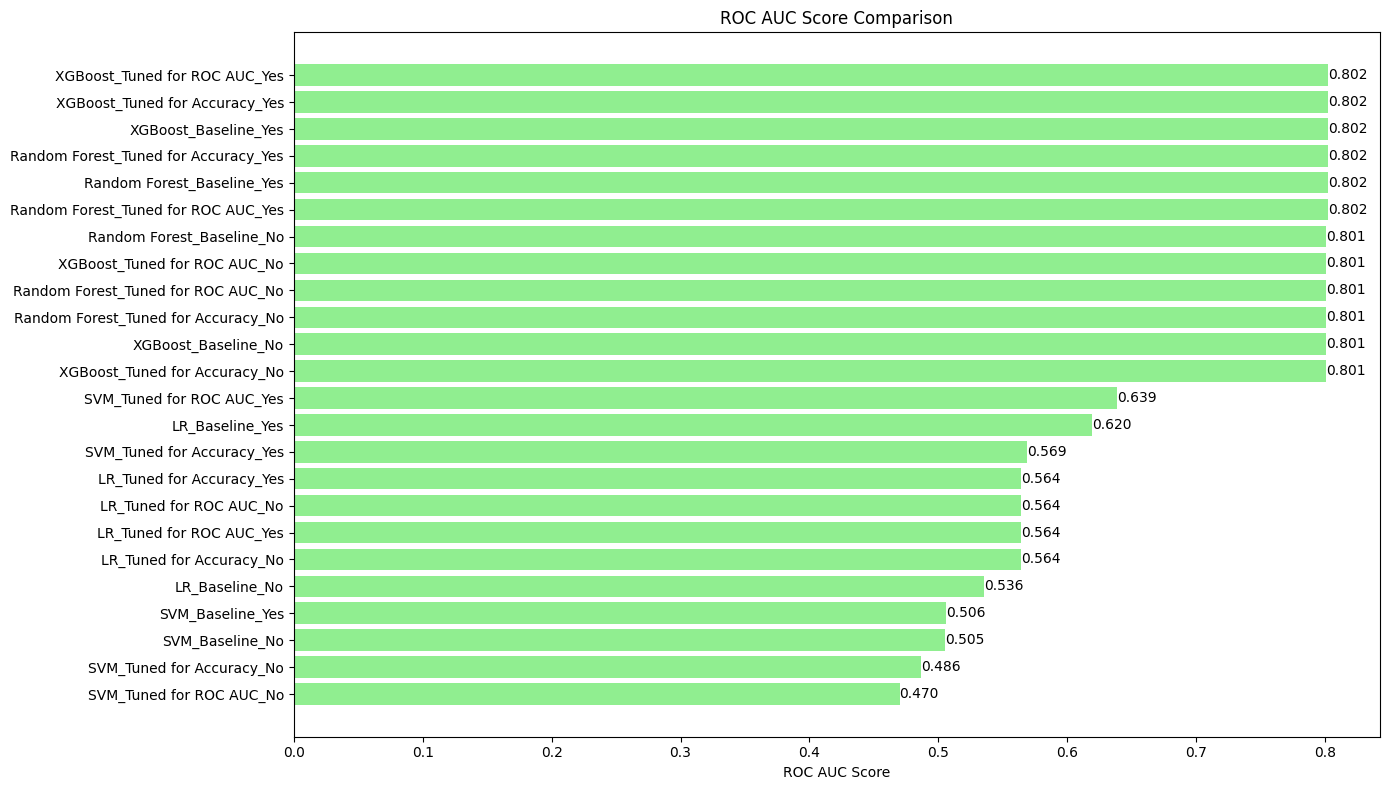

In [88]:
plot_metric_comparison(metrics_df, 'ROC AUC Score', 'ROC AUC Score Comparison',
                       color='lightgreen')

RF Tuned for Accuracy w/o Balancing seems to have the best balance between accuracy (0.399) and roc-auc score (0.802).

## Best Model Metrics

In [89]:
from pprint import pprint

best_model = metrics_df[metrics_df['Model_Configuration'] == "Random Forest_Tuned for Accuracy_No"]

if not best_model.empty:
  row = best_model.iloc[0]
  for col in best_model.columns:
    if col in ['Confusion Matrix', 'Classification Report']: # pretty print
      print(f"{col}:")
      pprint(row[col])
    else: # normal print
      print(f"{col}: {row[col]}")
  print("\n---\n")
else:
  print("No details found")

Model: Random Forest
Condition: Tuned for Accuracy
isBalanced: No
Accuracy: 0.36726546906187624
ROC AUC Score: 0.8007685333746793
Confusion Matrix:
array([[ 5, 12,  5,  2,  1,  0,  0],
       [ 6, 13, 21,  9,  3,  0,  0],
       [ 2,  6, 35, 29, 11,  0,  0],
       [ 0, 12, 22, 47, 37,  4,  0],
       [ 0,  2,  5, 45, 39, 29,  0],
       [ 0,  0,  2, 12, 34, 45,  0],
       [ 0,  0,  0,  0,  0,  6,  0]])
Classification Report:
{'0': {'f1-score': 0.2631578947368421,
       'precision': 0.38461538461538464,
       'recall': 0.2,
       'support': 25},
 '1': {'f1-score': 0.26804123711340205,
       'precision': 0.28888888888888886,
       'recall': 0.25,
       'support': 52},
 '2': {'f1-score': 0.40462427745664736,
       'precision': 0.3888888888888889,
       'recall': 0.42168674698795183,
       'support': 83},
 '3': {'f1-score': 0.35338345864661647,
       'precision': 0.3263888888888889,
       'recall': 0.38524590163934425,
       'support': 122},
 '4': {'f1-score': 0.3183673469387

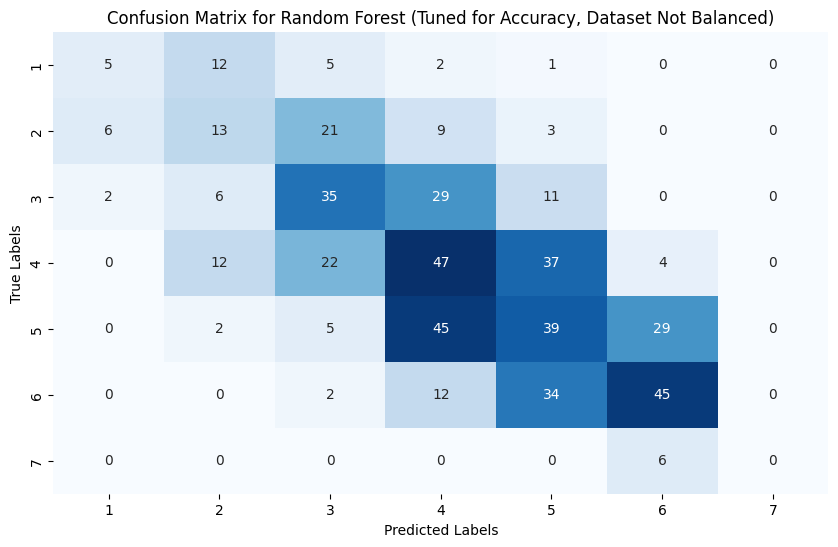

In [90]:
cm = best_model.iloc[0]['Confusion Matrix']

# reindexing labels to start from 1
labels = [str(i) for i in range(1, len(cm) + 1)]

# plot
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Random Forest (Tuned for Accuracy, Dataset Not Balanced)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()